In [ ]:
# Lab 1 – Unsupervised Learning (Clustering)

## Analysis of Daily Traffic Patterns at a Border Crossing Point

**Dataset:** Daily traffic statistics  
**Border Crossing Point:** CAHUL  
**Task:** Unsupervised clustering  

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt

In [ ]:
## Objective

The objective of this laboratory work is to apply and compare several
unsupervised learning algorithms in order to identify hidden structures
in daily traffic data.

The task focuses on clustering days with similar traffic characteristics
without using predefined labels.

In [ ]:
## Data Description

The dataset contains daily statistics of border crossings.
Each record corresponds to one calendar day.

To ensure meaningful clustering, the analysis is performed for a single
border crossing point (CAHUL), as each PCTF has its own traffic profile
and operational specifics.

In [3]:
# =========================
# 1) Load data + choose PCTF
# =========================
PCTF = "CAHUL"
df = pd.read_csv("../data/traffic_auto_daily.csv")

# Convert date column to datetime (safe parsing)
df["data"] = pd.to_datetime(df["data"], errors="coerce")

# Keep only one border crossing point (local clustering per PCTF)
df_one = df[df["pctf"] == PCTF].copy()

print("PCTF:", PCTF, "rows:", len(df_one))
df_one.head()

PCTF: CAHUL rows: 1096


,pctf,data,intrare_day,iesire_day,total_day,car_in,car_out,bus_in,bus_out,light_trucks_in,light_trucks_out,trucks_in,trucks_out,zi_sapt,month,is_weekend
2192,CAHUL,2022-12-01,512,447,959,267,288,6,14,5,14,234,131,4,12,0
2193,CAHUL,2022-12-02,431,393,824,275,271,6,8,6,11,144,103,5,12,0
2194,CAHUL,2022-12-03,431,528,959,297,374,6,6,10,10,118,138,6,12,1
2195,CAHUL,2022-12-04,521,719,1240,360,592,11,12,6,8,144,107,7,12,1
2196,CAHUL,2022-12-05,452,496,948,268,310,15,9,10,13,159,164,1,12,0


In [267]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25208 entries, 0 to 25207
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   pctf              25208 non-null  object        
 1   data              25208 non-null  datetime64[ns]
 2   intrare_day       25208 non-null  int64         
 3   iesire_day        25208 non-null  int64         
 4   total_day         25208 non-null  int64         
 5   car_in            25208 non-null  int64         
 6   car_out           25208 non-null  int64         
 7   bus_in            25208 non-null  int64         
 8   bus_out           25208 non-null  int64         
 9   light_trucks_in   25208 non-null  int64         
 10  light_trucks_out  25208 non-null  int64         
 11  trucks_in         25208 non-null  int64         
 12  trucks_out        25208 non-null  int64         
 13  zi_sapt           25208 non-null  int64         
 14  month             2520

In [ ]:
## Feature Selection

The following features were selected for clustering:

- `zi_sapt` – day of the week (1–7)
- `is_weekend` – weekend indicator (0/1)
- `intrare_day` – number of inbound vehicles per day
- `iesire_day` – number of outbound vehicles per day

The feature `total_day` was excluded to avoid linear dependency,
as it is the sum of inbound and outbound flows.

In [4]:
# =========================
# 2) Feature selection
# =========================
# We cluster "days" based on daily flow intensity + calendar context.
# Note: total_day is excluded to avoid linear dependency (total = intrare + iesire).

feature_cols = [
    "zi_sapt",          # day of week (1..7)
    "is_weekend",       # weekend flag (0/1)
    "intrare_day",      # daily inbound flow
    "iesire_day"        # daily outbound flow
]

print("Features:", feature_cols)

X = df_one[feature_cols].copy()

Features: ['zi_sapt', 'is_weekend', 'intrare_day', 'iesire_day']


In [ ]:
## Data Preprocessing

Before applying clustering algorithms, the data was standardized
using `StandardScaler`, since distance-based methods are sensitive
to feature scales.

Principal Component Analysis (PCA) was applied only for visualization
purposes, reducing the data to two dimensions.

In [6]:
# =========================
# 3) Standardization (important for distance-based algorithms)
# =========================
# StandardScaler -> mean=0, std=1 for each feature

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# =========================
# 4) PCA (2D) for visualization only
# =========================
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_scaled)

print("PCA explained variance (2 components):", pca.explained_variance_ratio_.sum())

PCA explained variance (2 components): 0.8764906429778841


In [10]:
def safe_silhouette(X, labels):
    """
    Silhouette needs at least 2 clusters.
    For DBSCAN, label = -1 means noise -> we compute silhouette on non-noise points only.
    """
    uniq = set(labels)
    if len(uniq) < 2 or uniq == {-1}:
        return None
    if -1 in uniq:
        mask = labels != -1
        if len(set(labels[mask])) < 2:
            return None
        return silhouette_score(X[mask], labels[mask])
    return silhouette_score(X, labels)

def plot_clusters(X2d, labels, title):
    """2D scatter plot in PCA space."""
    plt.figure()
    plt.scatter(X2d[:,0], X2d[:,1], c=labels, s=10)
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.title(title)
    plt.show()

In [ ]:
## KMeans Clustering

KMeans is a partitional clustering algorithm that divides data into
a predefined number of clusters by minimizing the within-cluster
sum of squared distances to cluster centroids.

In this experiment, the number of clusters was set to 4 in order to
capture different levels of daily traffic intensity.

In [16]:
# =========================
# 5) Algorithm 1: KMeans (partitional clustering)
# =========================
# Idea: minimize within-cluster sum of squares, prototype = centroid.
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
labels_km = kmeans.fit_predict(X_scaled)

sil_km = silhouette_score(X_scaled, labels_km)
sil_km

0.45976210741359747

In [17]:
#Clusters identified by KMeans
df_one["cluster"] = labels_km
cluster_profile = (
    df_one
    .groupby("cluster")[feature_cols]
    .mean()
    .round(1)
)

cluster_profile

,zi_sapt,is_weekend,intrare_day,iesire_day
cluster,,,,
0,2.8,0.0,516.8,543.0
1,3.4,0.0,824.4,808.1
2,6.5,1.0,569.7,587.2
3,6.5,1.0,1007.3,937.6


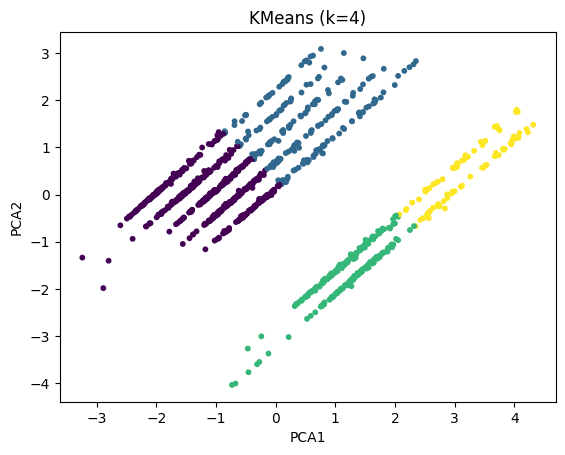

In [18]:
plot_clusters(X_2d, labels_km, "KMeans (k=4)")

In [ ]:
## Agglomerative Clustering

Agglomerative clustering is a hierarchical method that starts with each
data point as a separate cluster and iteratively merges the closest clusters.

Ward linkage was used, which minimizes the increase in intra-cluster variance
at each merging step.

In [19]:
# =========================
# 6) Algorithm 2: Agglomerative (hierarchical clustering)
# =========================
# Idea: start with each point as a cluster, merge clusters step-by-step (Ward linkage).
agg = AgglomerativeClustering(n_clusters=4, linkage="ward")
labels_agg = agg.fit_predict(X_scaled)

sil_agg = silhouette_score(X_scaled, labels_agg)
sil_agg

0.46120538876190054

In [15]:
#Clusters identified by Agglomerative
df_one["cluster"] = labels_agg
cluster_profile = (
    df_one
    .groupby("cluster")[feature_cols]
    .mean()
    .round(1)
)

cluster_profile

,zi_sapt,is_weekend,intrare_day,iesire_day
cluster,,,,
0,3.0,0.0,553.5,572.8
1,6.5,1.0,994.2,896.7
2,6.5,1.0,555.4,588.6
3,2.9,0.0,907.6,889.8


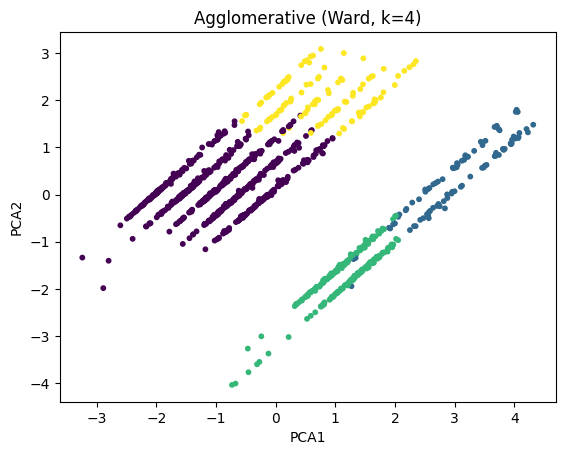

In [14]:
plot_clusters(X_2d, labels_agg, "Agglomerative (Ward, k=4)")

In [ ]:
## DBSCAN

DBSCAN is a density-based clustering algorithm that identifies clusters
as regions of high point density.

One of its advantages is the ability to detect noise points,
which correspond to atypical or anomalous days with unusual traffic patterns.

In [27]:
# =========================
# 7) Algorithm 3: DBSCAN (density-based clustering)
# =========================
# Idea: clusters are dense regions; points in sparse regions become noise (-1).
db = DBSCAN(eps=1.2, min_samples=10)
labels_db = db.fit_predict(X_scaled)

sil_db = safe_silhouette(X_scaled, labels_db)
sil_db

0.4724680294975549

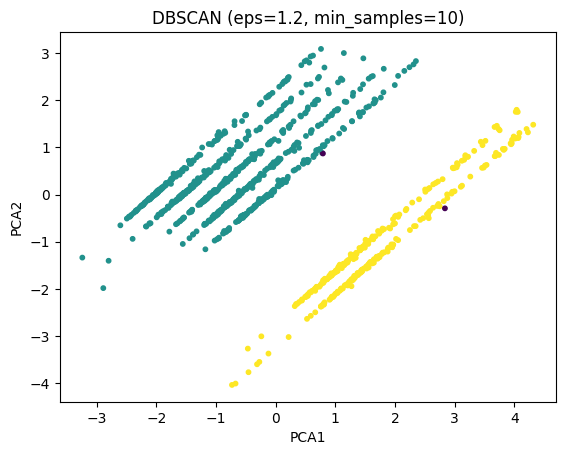

In [28]:
plot_clusters(X_2d, labels_db, "DBSCAN (eps=1.2, min_samples=10)")

In [31]:
#Noise points
n_total = len(labels_db)
n_noise = (labels_db == -1).sum()
n_clusters_db = len(set(labels_db)) - (1 if -1 in set(labels_db) else 0)

print(f"DBSCAN: noise={n_noise}/{n_total} ({n_noise/n_total:.2%}), clusters={n_clusters_db}")

DBSCAN: noise=2/1096 (0.18%), clusters=2


In [32]:
#Clusters identified by DBSCAN
df_one["cluster"] = labels_db
cluster_profile = (
    df_one
    .groupby("cluster")[feature_cols]
    .mean()
    .round(1)
)

cluster_profile

,zi_sapt,is_weekend,intrare_day,iesire_day
cluster,,,,
-1,6.0,0.5,1255.5,451.5
0,3.0,0.0,606.2,620.9
1,6.5,1.0,683.3,680.6


In [ ]:
## Gaussian Mixture Model (GMM)

Gaussian Mixture Model assumes that the data is generated from a mixture
of several Gaussian distributions.

Unlike KMeans, GMM provides a probabilistic assignment of data points
to clusters, allowing more flexible cluster shapes.

In [33]:
# =========================
# 8) Algorithm 4: Gaussian Mixture Model (probabilistic / EM)
# =========================
# Idea: data is generated by a mixture of Gaussians; EM estimates parameters and assigns clusters.
gmm = GaussianMixture(n_components=4, random_state=42)
labels_gmm = gmm.fit_predict(X_scaled)

sil_gmm = silhouette_score(X_scaled, labels_gmm)
sil_gmm

0.4074477096027474

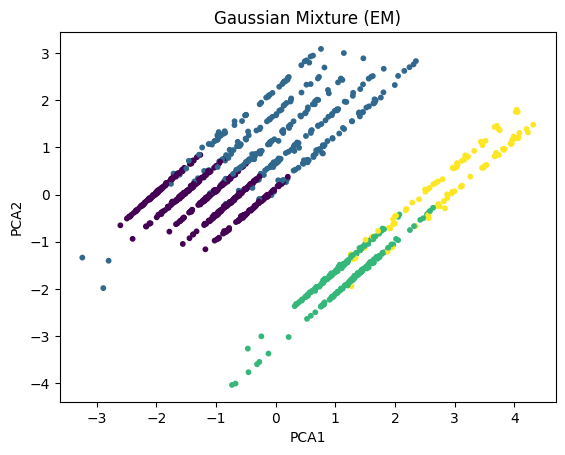

In [34]:
plot_clusters(X_2d, labels_gmm, "Gaussian Mixture (EM)")

In [35]:
#Clusters identified by Gaussian Mixture Model
df_one["cluster"] = labels_gmm
cluster_profile = (
    df_one
    .groupby("cluster")[feature_cols]
    .mean()
    .round(1)
)

cluster_profile

,zi_sapt,is_weekend,intrare_day,iesire_day
cluster,,,,
0,3.0,0.0,516.4,529.2
1,3.1,0.0,764.8,780.1
2,6.5,1.0,560.8,592.0
3,6.5,1.0,981.3,888.6


In [43]:
# =========================
# 9) Comparative evaluation table
# =========================
results = pd.DataFrame({
    "Algoritm": ["KMeans", "Agglomerative", "DBSCAN", "GMM"],
    "Silhouette": [sil_km, sil_agg, sil_db, sil_gmm],
    "Noise_points(DBSCAN)": [np.nan, np.nan, (labels_db==-1).sum(), np.nan]
})

results

,Algoritm,Silhouette,Noise_points(DBSCAN)
0,KMeans,0.459762,NaN
1,Agglomerative,0.461205,NaN
2,DBSCAN,0.472468,2.0
3,GMM,0.407448,NaN


In [ ]:
## Evaluation and Conclusions

Clustering quality was evaluated using the silhouette score.
For DBSCAN, the silhouette score was computed only for non-noise points.

The results show that KMeans and Agglomerative clustering provide
stable and interpretable groupings of daily traffic patterns.
DBSCAN successfully identifies anomalous days,
while GMM offers a probabilistic view of cluster structure.

Overall, unsupervised learning methods proved effective in discovering
hidden patterns in daily border traffic data.